# Generative Adversarial Network (GAN)

![](https://nbviewer.jupyter.org/github/hse-aml/intro-to-dl/blob/master/week4/images/gan.png)

Пришло время поговорить о более интересных архитектурах, а именно о GANах или состязательных нейронных сетках. [Впервые GANы были предложены в 2014 году.](https://arxiv.org/abs/1406.2661) Сейчас они очень активно исследуются. GANы состоят из двух нейронных сетей: 

* Первая - генератор порождает из некоторого заданного распределения случайные числа и собирает из них объекты, которые идут на вход второй сети. 
* Вторая - дискриминатор получает на вход объекты из реальной выборки и объекты, созданные генератором. Она пытается определить какой объект был порождён генератором, а какой является реальным.

Таким образом генератор пытается создавать объекты, которые дискриминатор не сможет отличить от реальных. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import time 

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Данные

Для начала давайте попробуем погонять модели на рукописных цифрах из MNIST как бы скучно это не было. 

In [3]:
(X, _ ), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
X = X/127.5 - 1 # отнормировали данные на отрезок [-1, 1]

In [5]:
X.min(), X.max()  # проверили нормировку

(-1.0, 1.0)

In [6]:
# наша ламповый датасет из Cимпсонов
X = X[:,:,:,np.newaxis]
X.shape

(60000, 28, 28, 1)

Давайте вытащим несколько рандомных картинок и нарисуем их.

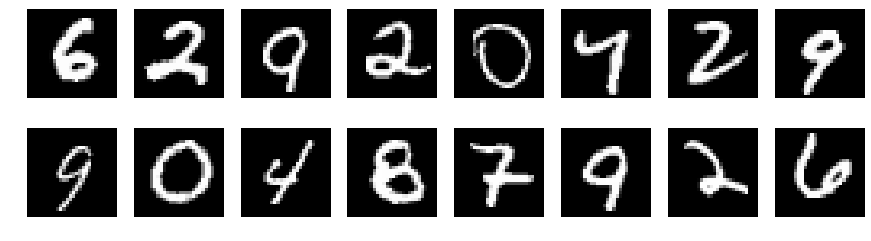

In [7]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(np.squeeze(X,-1)[random_index, :], cmap='gray')
plt.show()

Соберём для наших данных удобный генератор. 

# 2. Дискриминатор 

* Дискриминатор - это обычная свёрточная сетка 
* Цель этой сетки - отличать сгенерированные изображения от реальных

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L

In [9]:
IMG_SHAPE = X.shape[1:]

In [10]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))
discriminator.add(L.Conv2D(16, kernel_size=(3,3), activation='elu', padding='same'))
discriminator.add(L.MaxPool2D())

discriminator.add(L.Conv2D(32, kernel_size=(3,3), activation='elu', padding='same'))
discriminator.add(L.MaxPool2D())

# discriminator.add(L.Conv2D(64, kernel_size=(3,3), padding='same',activation='elu'))
# discriminator.add(L.MaxPool2D())

discriminator.add(L.Flatten())
discriminator.add(L.Dense(128,activation='tanh'))

# на выход из дискриминатора мы забираем логарифм, а не вероятность 
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

# 3. Генератор

* Генерирует из шума изображения 

Будем генерировать новые цифры из шума размера `code_size`.

In [11]:
CODE_SIZE = 128

In [12]:
# generator = Sequential()

# generator.add(L.InputLayer([CODE_SIZE],name='noise'))
# generator.add(L.Dense(10*7*7, activation='elu'))
# generator.add(L.BatchNormalization())
# generator.add(L.Reshape((7,7,10)))

# generator.add(L.Conv2DTranspose(64, (5, 5), strides=(1, 1), activation='elu', padding='same'))
# generator.add(L.BatchNormalization())
    
# generator.add(L.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='elu', padding='same'))
# generator.add(L.Conv2DTranspose(32, (3, 3), activation='elu', padding='same'))
# generator.add(L.BatchNormalization())

# generator.add(L.Conv2DTranspose(1, (3, 3), strides=(2, 2), activation='tanh', padding='same'))
# generator.add(L.Conv2D(1, kernel_size=3, padding='same'))
# generator.output_shape == (None, 28, 28, 1)


generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(128*7*7, activation='elu'))
generator.add(L.Reshape((7,7,128)))
generator.add(L.Conv2DTranspose(128, kernel_size=(3,3)))
generator.add(L.LeakyReLU())
generator.add(L.Conv2DTranspose(64, kernel_size=(3,3)))
generator.add(L.LeakyReLU())
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2D(1, kernel_size=3, padding='same'))
generator.output_shape == (None, 28, 28, 1)

True

In [13]:
generator.output_shape

(None, 28, 28, 1)

Посмотрим на пример, который нам генерирует на выход наша свежая нейронка! 

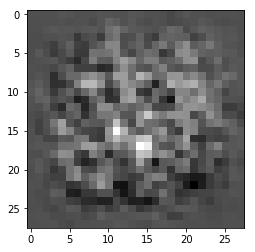

In [14]:
noise = tf.random.normal([1, CODE_SIZE])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

Хммм... А что про это всё думает дескриминатор?

In [15]:
decision = discriminator(generated_image)

# на выход из дискриминатора мы забираем логарифм!
tf.nn.softmax(decision)

<tf.Tensor: id=723, shape=(1, 2), dtype=float32, numpy=array([[0.47104946, 0.5289505 ]], dtype=float32)>

# 4. Функция потерь 

Потери для дескриминатора это обычныя кросс-энтропия.

In [16]:
def discriminator_loss(logp_real, logp_gen):
    d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
    
    # немного регуляризации, чтобы не запомнить базовую выборку
    d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)
    return d_loss

In [17]:
real_log = discriminator(X[:1])
gen_log = discriminator(generated_image)

discriminator_loss(real_log, gen_log)

W0308 14:53:09.610878 140736691479488 base_layer.py:1814] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=791, shape=(), dtype=float32, numpy=0.9858628>

Для генератора мы хотим максимизировать ошибку дискриминатора на фэйковых примерах. 

In [18]:
def generator_loss(logp_gen):
    return tf.reduce_mean(logp_gen[:,0])

In [19]:
generator_loss(gen_log)

<tf.Tensor: id=797, shape=(), dtype=float32, numpy=-0.7527922>

# 5. Градиентный спуск

Учить пару из сеток будем так: 

* Делаем $k$ шагов обучения дискриминатора. Целевая переменная - реальный объект перед нами или порождённый. Веса изменяем стандартно, пытаясь уменьшить кросс-энтропию.
* Делаем $m$ шагов обучения генератора. Веса внутри сетки меняем так, чтобы увеличить логарифм вероятности дискриминатора присвоить сгенерированному объекту лэйбл реального. 
* Обучаем итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (либо пока у нас не закончится терпение).
* При обучении может возникнуть огромное количество пробем от взрыва весов до более тонких вещей. Имеет смысл посмотреть на разные трюки, используемые при обучении:  https://github.com/soumith/ganhacks

Собираем структуру для обучения.

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(1e-3)

Чекпойнты для процесса обучения.

In [21]:
import os 
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Задаём один шаг процедуры обучения генератора.

In [22]:
@tf.function
def train_generator_step(images, noise):

    # ищем градиенты 
    with tf.GradientTape() as gen_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        gen_loss = generator_loss(fake_output)
        
    # нашли градиенты
    grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    generator_optimizer.apply_gradients(zip(grad, generator.trainable_variables))

Теперь шаг обучения дискриминатора. 

In [23]:
@tf.function
def train_discriminator_step(images, noise):
    
    # ищем градиенты 
    with tf.GradientTape() as disc_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # нашли градиенты
    grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    discriminator_optimizer.apply_gradients(zip(grad, discriminator.trainable_variables))

Мы почти готовы учить нашу сетку. Напишем две простенькие функции для генерации фэйковых и настоящих батчей. 

In [24]:
# функция, которая генерирует батч с шумом
def sample_noise_batch(bsize):
    return tf.random.normal([bsize, CODE_SIZE], dtype=tf.float32)


# функция, которая генерирует батч из реальных данных (для баловства)
def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(X.shape[0]), size=bsize)
    return X[idxs]

Проверяем отрабатывают ли наши шаги.

In [25]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.9940212
Ошибка генератора: -0.73509943


In [26]:
# сделали шаг работы генератора
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.0106113
Ошибка генератора: -0.75168955


In [27]:
# сделали шаг работы дискриминатора
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.9284157
Ошибка генератора: -0.75336766


Как думаете, выглядит адекватно? Мы нигде не ошиблись? 

Напишем пару вспомогательных функций для отрисовки картинок. 

In [28]:
# рисуем изображения
def sample_images(rows, cols, num=0):
    images = generator.predict(sample_noise_batch(bsize=rows*cols))
    
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(np.squeeze(images[i * rows + j],-1),cmap='gray')
    
    # сохраняем картинку для гифки
    if num >0:
        plt.savefig('images_gan/image_at_epoch_{:04d}.png'.format(num))
    plt.show()
    
# рисуем распределения
def sample_probas(X):
    plt.title('Generated vs real data')
    
    plt.hist(np.exp(discriminator.predict(X))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(X.shape[0]))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    
    plt.legend(loc='best')
    plt.show()
    

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


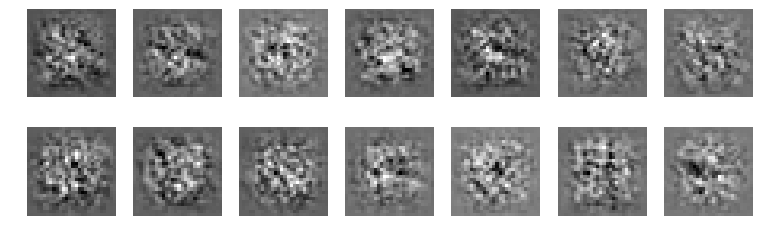

In [29]:
sample_images(2,7)

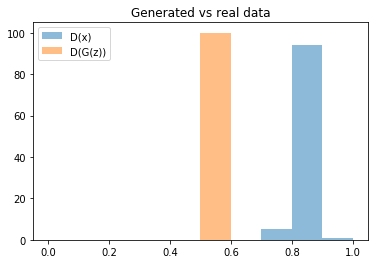

In [30]:
sample_probas(X[:100]) 

Немного побалуемся с шагами. 

In [31]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Генератор
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.9331659
Ошибка генератора: -0.7588117


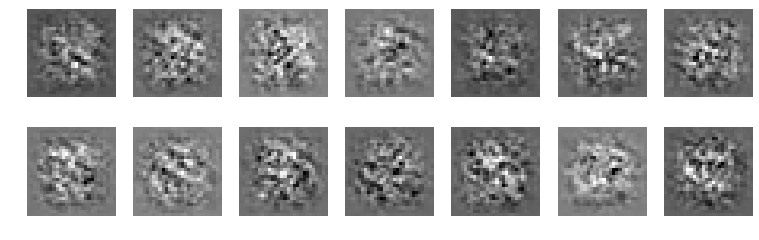

In [32]:
sample_images(2,7)

In [33]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Дискриминатор
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 0.8732006
Ошибка генератора: -0.75326025


# 6. Обучение

Ну и наконец последний шаг. Тренировка сеток.  При обучении нужно соблюдать между сетками баланс. Важно сделать так, чтобы ни одна из них не стала сразу же побеждать. Иначе обучение остановится. 

* Чтобы избежать моментального выигрыша дискриминатора, мы добавили в его функцию потерь $l_2$ регуляризацию. 
* Кроме регуляризации можно пытаться учить модели сбалансированно, делая внутри цикла шаги чуть более умным способом. 


In [34]:
# Эксперименты с совместным обучением (так цикл работает быстре)
@tf.function
def train_step(images, noise):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) 

Time for epoch 1 is 0.027430284768342972 min
error D: 0.8639708161354065, error G: -0.7754840850830078


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


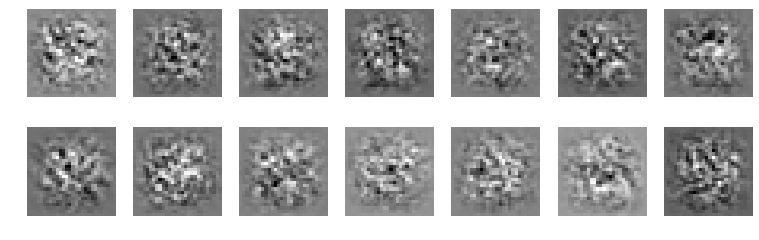

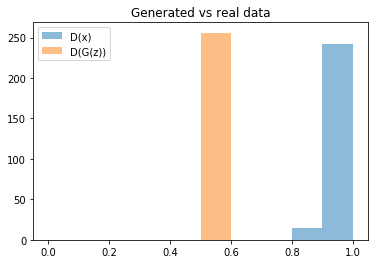

Time for epoch 21 is 0.36770498007535934 min
error D: 0.27247822284698486, error G: -0.16846612095832825


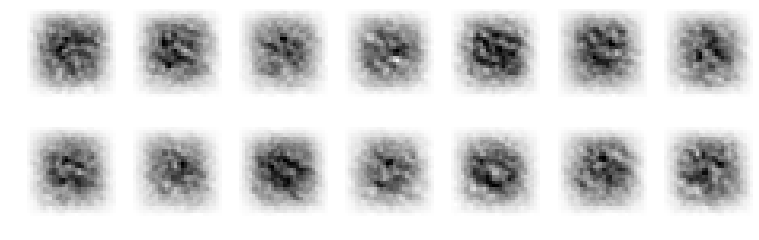

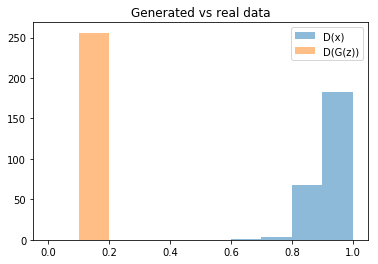

Time for epoch 41 is 0.7331195995211601 min
error D: 3.2630460262298584, error G: -3.18644118309021


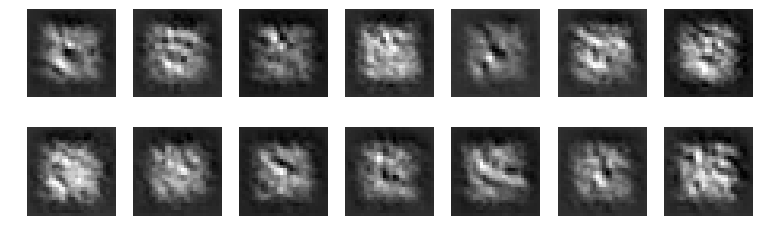

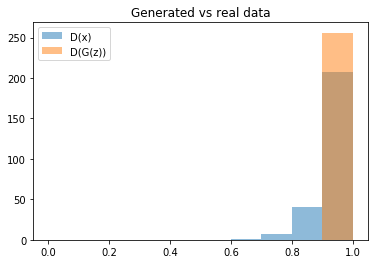

Time for epoch 61 is 1.1119315288960934 min
error D: 0.042763181030750275, error G: -0.00033684365916997194


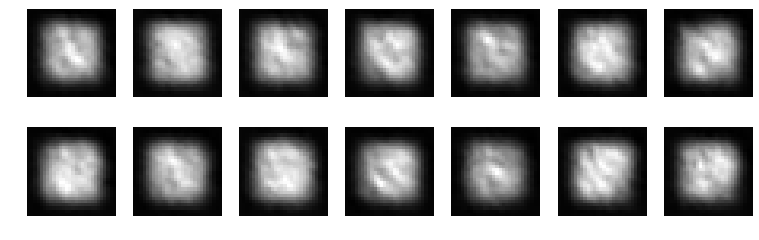

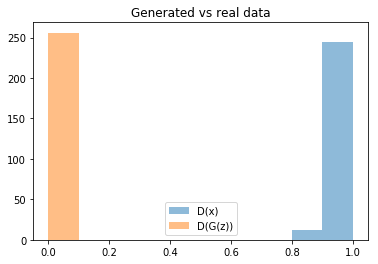

Time for epoch 81 is 1.4914860501885414 min
error D: 0.020885435864329338, error G: -2.4274891075037885e-06


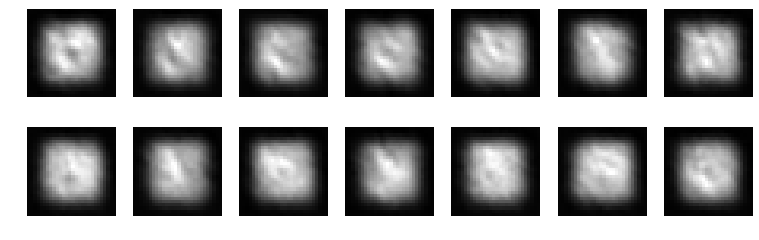

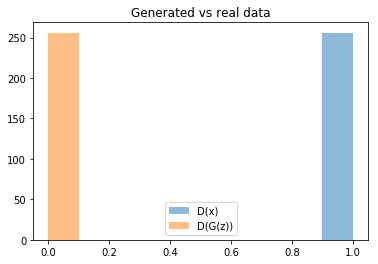

Time for epoch 101 is 1.865918930619955 min
error D: 0.019637610763311386, error G: -1.416540726495441e-06


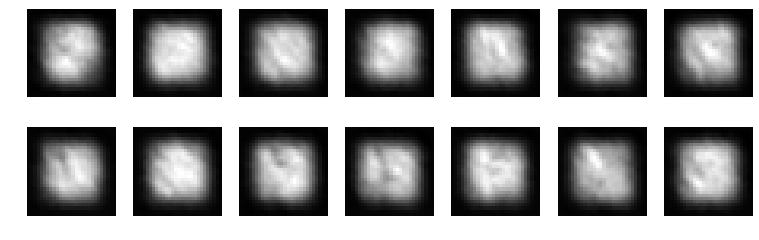

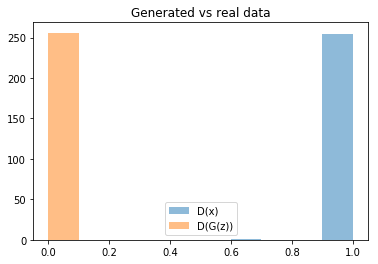

Time for epoch 121 is 2.238513845950365 min
error D: 0.017000745981931686, error G: -1.2372613582556369e-06


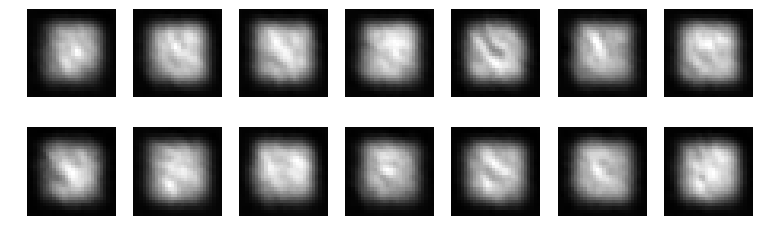

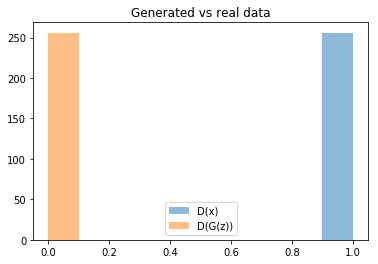

Time for epoch 141 is 2.607820548117161 min
error D: 0.01648220792412758, error G: -1.195817503685248e-06


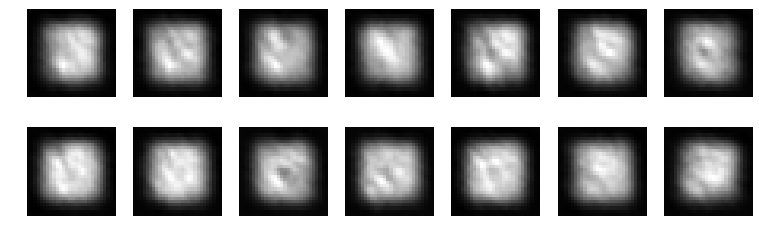

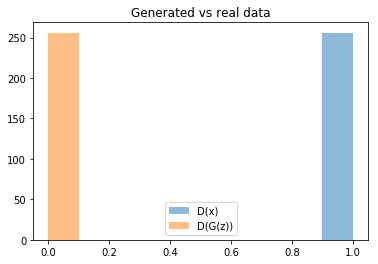

Time for epoch 161 is 2.9732409305870533 min
error D: 0.016347765922546387, error G: -1.217237922901404e-06


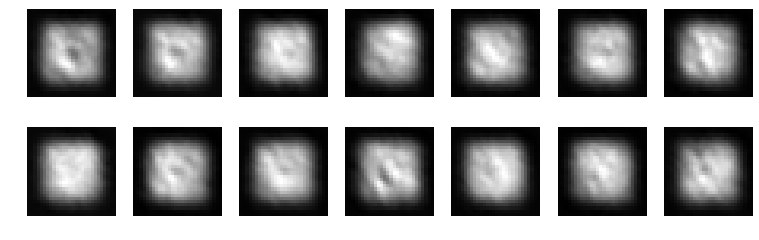

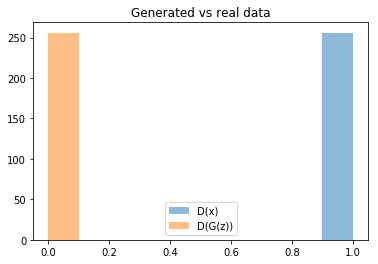

Time for epoch 181 is 3.3379688672721386 min
error D: 0.016264842823147774, error G: -1.2260854873602511e-06


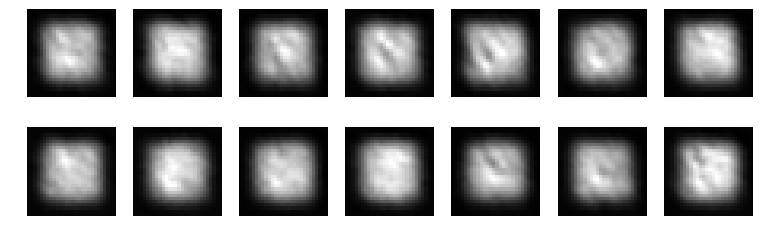

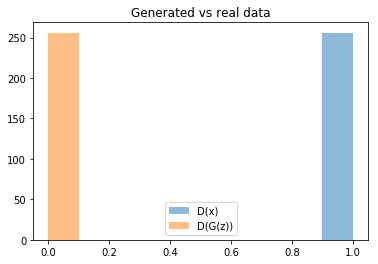

Time for epoch 201 is 3.7038202472031116 min
error D: 0.015860624611377716, error G: -1.2004741165583255e-06


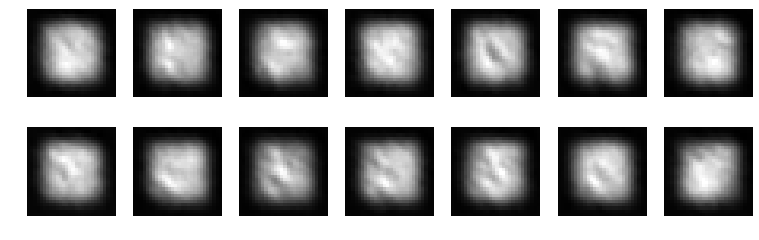

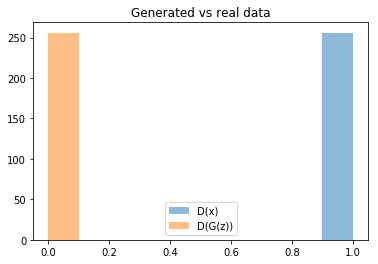

Time for epoch 221 is 4.071998331695795 min
error D: 0.015799453482031822, error G: -1.208390358442557e-06


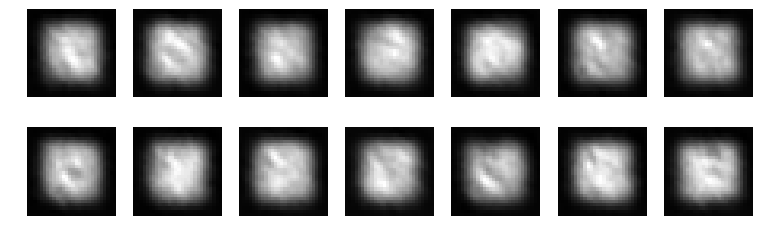

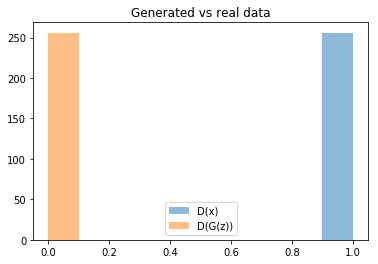

Time for epoch 241 is 4.4375309981405735 min
error D: 0.015810087323188782, error G: -1.2158409390394809e-06


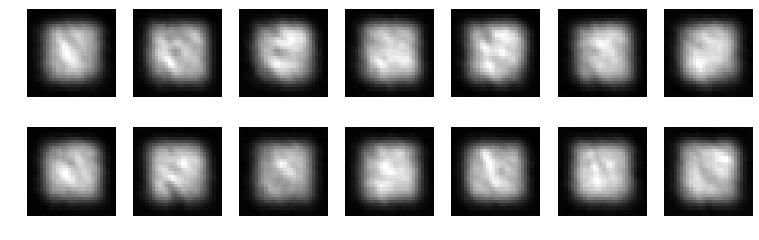

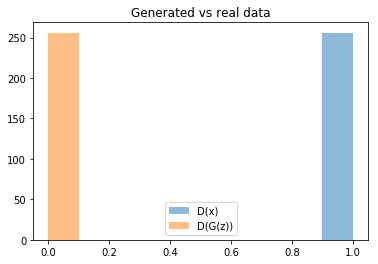

Time for epoch 261 is 4.804433282464743 min
error D: 0.01572832278907299, error G: -1.2097873423044803e-06


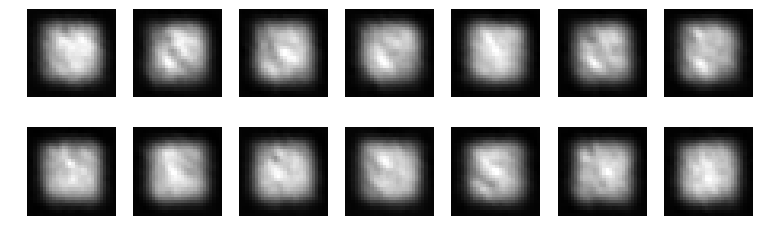

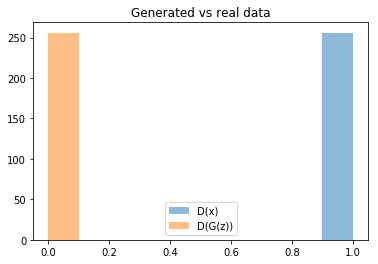

Time for epoch 281 is 5.170727729797363 min
error D: 0.015575172379612923, error G: -1.2186349067633273e-06


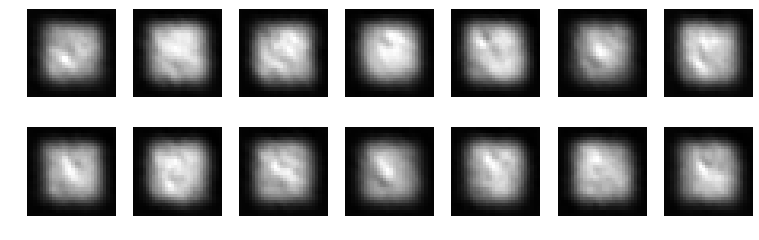

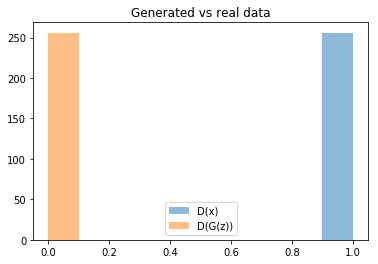

In [35]:
from IPython import display

EPOCHS = 300
BSIZE = 256

# время
start = time.time()/60

# вектора для мониторинга сходимости сеток
d_losses = [ ]
g_losses = [ ]

num = 0 # для сохранения картинок 

# запускаем цикл обучения 
for epoch in range(EPOCHS):
    
    # генерируем батч
    X_batch = sample_data_batch(BSIZE)
    X_fake = sample_noise_batch(BSIZE)
    
    # делаем N шагов обучения дискриминатора
#     for i in range(5):
#         train_discriminator_step(X_batch, X_fake)
        
#     # делаем K шагов обучения генератора
#     for i in range(1):
#         train_generator_step(X_batch, X_fake)

    train_step(X_batch, X_fake)
    
    gen_log = discriminator(generator(X_fake))
    real_log = discriminator(X_batch) 
    
    d_losses.append(discriminator_loss(real_log, gen_log).numpy())
    g_losses.append(generator_loss(gen_log).numpy())
        
    # ну сколько можно ждааать!!! 
    if epoch % 20==0:
        print('Time for epoch {} is {} min'.format(epoch + 1, time.time()/60-start))
        print('error D: {}, error G: {}'.format(d_losses[-1], g_losses[-1]))

    if epoch % 20==0:
        # сохраняем модель и обновляем картинку
        # checkpoint.save(file_prefix = checkpoint_prefix)

        # можно раскоментировать, если хочется, чтобы картинка обновлялась, а не дополнялас
        #display.clear_output(wait=True)
        num += 1
        sample_images(2,7, num)
        sample_probas(X_batch)

Тренируем сетки.

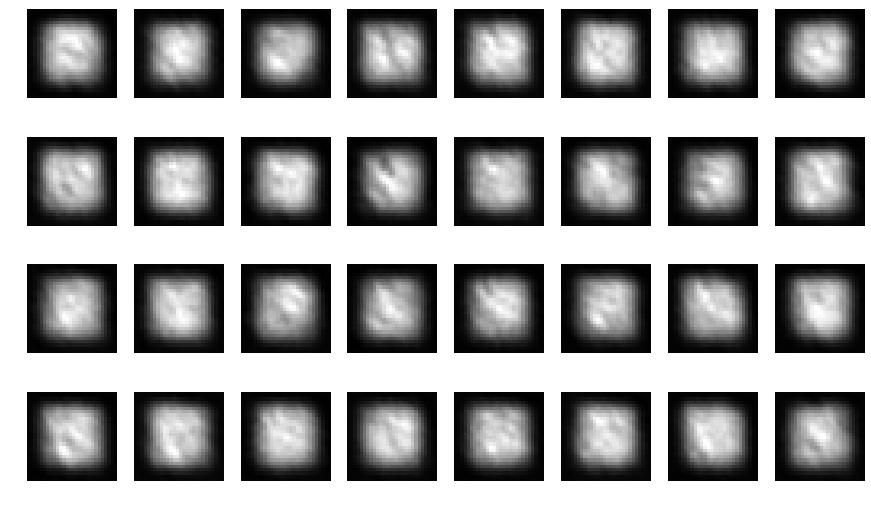

In [36]:
# сетка тренировалась много итераций
sample_images(4,8)  

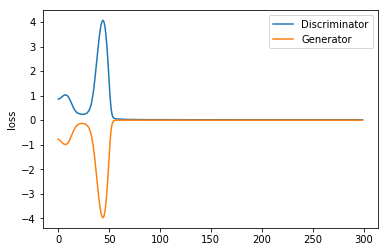

In [37]:
# смотрим сошлись ли потери
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.ylabel('loss')
plt.legend();

# 7. Интерполяция 

Давайте попробуем взять два вектора, сгенерированных из нормального распределения и посмотреть как один из них перетекакет в другой. 

In [44]:
from scipy.interpolate import interp1d

def show_interp_samples(point1, point2, N_samples_interp):
    N_samples_interp_all = N_samples_interp + 2

    # линия между двумя точками
    line = interp1d([1, N_samples_interp_all], np.vstack([point1, point2]), axis=0)

    fig = plt.figure(figsize=(15,4))
    for i in range(N_samples_interp_all):
        ax = fig.add_subplot(1, 2 + N_samples_interp, i+1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(generator.predict(line(i + 1).reshape((1, 100)))[0, :, :, 0],cmap='gray')
    plt.show()
    pass

ValueError: cannot reshape array of size 100 into shape (1,128)

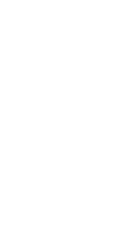

In [43]:
np.random.seed(seed=42)

# Рандомная точка в пространстве
noise_1 = np.random.normal(0, 1, (1, 100))

# смотрим как она перетекает в симметричкную
show_interp_samples(noise_1, -noise_1, 6)

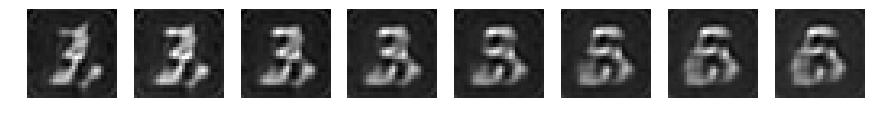

In [65]:
noise_2 = np.random.normal(0, 1, (1, 100))
show_interp_samples(noise_1, noise_2, 6)

А что мы вообще сгенерировали?! Давайте посмотрим на точку из выборки наиболее близкую к получившейся генерации.

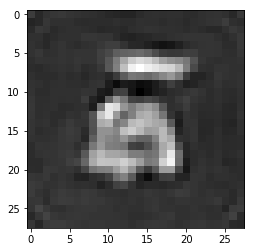

In [66]:
id_label_sample = 8
img_smp = generator.predict(sample_noise_batch(1))
plt.imshow(img_smp[0,:,:,0], cmap='gray')

In [67]:
img_smp.shape, X.shape

((1, 28, 28, 1), (60000, 28, 28, 1))

In [68]:
# ищем l1 норму между тем, что сгенерилось и остальным 
L1d = np.sum(np.sum(np.abs(X[:,:,:,0] - img_smp[:,:,:,0]), axis=1), axis=1)
idx_l1_sort = L1d.argsort()
idx_l1_sort.shape

(60000,)

In [69]:
idx_l1_sort[:5]

array([ 3919, 10440, 28678, 48398, 12088])

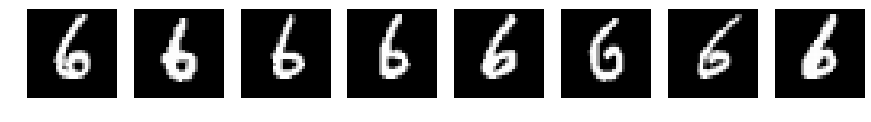

In [70]:
N_closest = 8

fig = plt.figure(figsize=(15,4))
for i in range(N_closest):
    ax = fig.add_subplot(1, N_closest, i+1)
    ax.grid('off')
    ax.axis('off')
    ax.imshow(X[idx_l1_sort[i], :, :, 0], cmap='gray')
plt.show()

Сохраняю гифку из картинок. 

In [72]:
import os
import glob
import imageio

def create_animated_gif(files, animated_gif_name, pause=0):
    if pause != 0:
        # Load the gifs up several times in the array, to slow down the animation
        frames = []
        for file in files:
            count = 0
            while count < pause:
                frames.append(file)
                count+=1
        print("Total number of frames in the animation:", len(frames))
        files = frames
    images = [imageio.imread(file) for file in files]
    imageio.mimsave(animated_gif_name, images, duration = 0.005)

In [74]:
pause = 1
animated_gif_name = 'animation_GAN.gif'

In [76]:
image_path = 'images_gan/*.png'
files = glob.glob(image_path)
files = sorted(files, key = lambda w: int(w.split('_')[-1].split('.')[0]))
create_animated_gif(files, animated_gif_name, pause)

Total number of frames in the animation: 133


# Задание: 

* Превратить нашу GAN в Conditional GAN 

![](https://camo.githubusercontent.com/63a263678253a1eedd74432ad85751da2407a3d8/687474703a2f2f6775696d70657261726e61752e636f6d2f66696c65732f626c6f672f46616e7461737469632d47414e732d616e642d77686572652d746f2d66696e642d7468656d2f6347414e5f6f766572766965772e6a7067)

На этом всё :) 

![](https://miro.medium.com/max/896/1*3VOLkgm-QY05gEpGDkBzTA.gif)